<a href="https://colab.research.google.com/github/GKS07/Computer_Vision/blob/main/Birds_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying 525 species of Birds using CNN and Transfer Learning.


we will use Transfer Learning to train our model to achieve decent validation score.

This Data set contains of 525 bird species. 84635 training images, 2625 test images(5 images per species) and 2625 validation images(5 images per species).

All images are 224 X 224 X 3 color images in jpg format. Data set includes a train set, test set and validation set.

**Downloading Data**

In [1]:
# uploading the kaggle jason file
from google.colab import files
files.upload()

# copying the kaggle file

!mkdir ~/.kaggle # nmaking the folder

! cp kaggle.json ~/.kaggle/  #copy the file

#changing the permission.
! chmod 600 ~/.kaggle/kaggle.json


# downloading the data from kaggle

!kaggle datasets download -d gpiosenka/100-bird-species

# making the folder
!mkdir birds


Saving kaggle.json to kaggle.json
 99% 1.93G/1.96G [00:24<00:00, 88.0MB/s]
100% 1.96G/1.96G [00:24<00:00, 86.0MB/s]


In [ ]:
#unzipping the data

!unzip 100-bird-species.zip -d birds

In [34]:
# importing the libraries

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout,Flatten, Dense, Rescaling
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
import seaborn as sns
import keras
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")


# Loading and Preprocessing the data.

In [4]:
#path of the data

train_ = '/content/birds/train'

valid_ = '/content/birds/valid'

test_  = '/content/birds/test'

In [5]:
# function for the number of images of each species of birds

def bird_species(folder_path):
  for sub_dir in os.listdir(folder_path):
      img_file = os.listdir(os.path.join(folder_path, sub_dir))
      print("The number of images of ",sub_dir, "is", len(img_file))


In [32]:
bird_species(train_)

The number of images of  EARED PITA is 154
The number of images of  ROCK DOVE is 132
The number of images of  MYNA is 141
The number of images of  NORTHERN MOCKINGBIRD is 140
The number of images of  LILAC ROLLER is 138
The number of images of  CABOTS TRAGOPAN is 177
The number of images of  COCK OF THE  ROCK is 163
The number of images of  BLACK-THROATED SPARROW is 168
The number of images of  JACK SNIPE is 159
The number of images of  BLUE GROSBEAK is 170
The number of images of  NORTHERN BEARDLESS TYRANNULET is 185
The number of images of  CRIMSON SUNBIRD is 198
The number of images of  LONG-EARED OWL is 160
The number of images of  EASTERN GOLDEN WEAVER is 152
The number of images of  EMPEROR PENGUIN is 152
The number of images of  BALTIMORE ORIOLE is 137
The number of images of  LOGGERHEAD SHRIKE is 190
The number of images of  BLACK AND YELLOW BROADBILL is 142
The number of images of  GREATER PEWEE is 157
The number of images of  HOOPOES is 155
The number of images of  EMU is 163

In [33]:
bird_species(valid_)

The number of images of  EARED PITA is 5
The number of images of  ROCK DOVE is 5
The number of images of  MYNA is 5
The number of images of  NORTHERN MOCKINGBIRD is 5
The number of images of  LILAC ROLLER is 5
The number of images of  CABOTS TRAGOPAN is 5
The number of images of  COCK OF THE  ROCK is 5
The number of images of  BLACK-THROATED SPARROW is 5
The number of images of  JACK SNIPE is 5
The number of images of  BLUE GROSBEAK is 5
The number of images of  NORTHERN BEARDLESS TYRANNULET is 5
The number of images of  CRIMSON SUNBIRD is 5
The number of images of  LONG-EARED OWL is 5
The number of images of  EASTERN GOLDEN WEAVER is 5
The number of images of  EMPEROR PENGUIN is 5
The number of images of  BALTIMORE ORIOLE is 5
The number of images of  LOGGERHEAD SHRIKE is 5
The number of images of  BLACK AND YELLOW BROADBILL is 5
The number of images of  GREATER PEWEE is 5
The number of images of  HOOPOES is 5
The number of images of  EMU is 5
The number of images of  LITTLE AUK is 5


**Preprocessing the data**

In [ ]:
# extracting 50 images from each folder, so that i can reduce the training time.
data = {"imgpath": [] , "labels": [] }

category = os.listdir(train_)
for folder in category:
    folderpath = os.path.join(train_ , folder)
    filelist = os.listdir(folderpath)
    #print(folder)
    for file in filelist[:50]:
        #print(file)
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)


In [36]:
# creating a dataframe from extracted data.
image_df = pd.DataFrame(data)

#Convert labels to numbers
lb = LabelEncoder()
image_df['encoded_labels'] = lb.fit_transform(image_df['labels'])

In [41]:
image_df.head(10)

imgpath      labels  encoded_labels
0  /content/birds/train/EARED PITA/092.jpg  EARED PITA             197
1  /content/birds/train/EARED PITA/006.jpg  EARED PITA             197
2  /content/birds/train/EARED PITA/132.jpg  EARED PITA             197
3  /content/birds/train/EARED PITA/033.jpg  EARED PITA             197
4  /content/birds/train/EARED PITA/078.jpg  EARED PITA             197
5  /content/birds/train/EARED PITA/049.jpg  EARED PITA             197
6  /content/birds/train/EARED PITA/139.jpg  EARED PITA             197
7  /content/birds/train/EARED PITA/089.jpg  EARED PITA             197
8  /content/birds/train/EARED PITA/135.jpg  EARED PITA             197
9  /content/birds/train/EARED PITA/029.jpg  EARED PITA             197

In [46]:
image_df.labels.value_counts()

EARED PITA                 50
PYGMY KINGFISHER           50
STORK BILLED KINGFISHER    50
WHITE BROWED CRAKE         50
EASTERN BLUEBIRD           50
                           ..
CROW                       50
RAZORBILL                  50
GREAT POTOO                50
SNOW GOOSE                 50
BEARDED BELLBIRD           50
Name: labels, Length: 525, dtype: int64

In [48]:
print("The shape of the training DF is:",image_df.shape)

The shape of the training DF is: (26250, 3)


In [56]:
batch_size = 15
img_size = 256

#data augmentaion

augmented_images = Sequential([
                                layers.experimental.preprocessing.RandomFlip("vertical"),
                                layers.experimental.preprocessing.RandomRotation(0.2),
                                layers.experimental.preprocessing.RandomZoom(0.2),
                                layers.experimental.preprocessing.RandomContrast(0.3),
                                ], name = 'Augmenting_images')

#generating data
img_generator = ImageDataGenerator(
                                  preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                                  #validation_split = 0.3
                                  )

test_generator = ImageDataGenerator(
                                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,

                                    )

#generating a training data
training_data = img_generator.flow_from_dataframe(image_df,
                                                  x_col = 'imgpath',
                                                  y_col = 'labels',
                                                    target_size = (img_size, img_size),
                                                    color_mode = 'rgb',
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    shuffle = True,
                                                    seed = 43,
                                                    subset = 'training'
                                                    )


#generating the validation data

validation_data = img_generator.flow_from_directory(valid_,
                                                      target_size = (img_size, img_size),
                                                      color_mode = 'rgb',
                                                      batch_size = batch_size,
                                                      class_mode = 'categorical',
                                                      #subset = 'validation',
                                                      shuffle = False
                                                      )


test_data = test_generator.flow_from_directory(test_,
                                               target_size = (img_size, img_size),
                                               color_mode = 'rgb',
                                               batch_size = batch_size,
                                               class_mode = 'categorical',
                                               #subset = 'validation'
                                               )



Found 26250 validated image filenames belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [57]:
# class of the training_data

CLASSES = [x for x in training_data.class_indices]

In [58]:
#shape of the image
print("the shape of the training images is:", training_data.image_shape)

the shape of the training images is: (256, 256, 3)


In [65]:
# defining the function to display the images.

def display_one_bird(image, title, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image*1./255)
  plt.title(title, fontsize=16, color=color)

# plotting the 9 images
def display_nine_birds(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(12,13))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_bird(images[i], titles[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

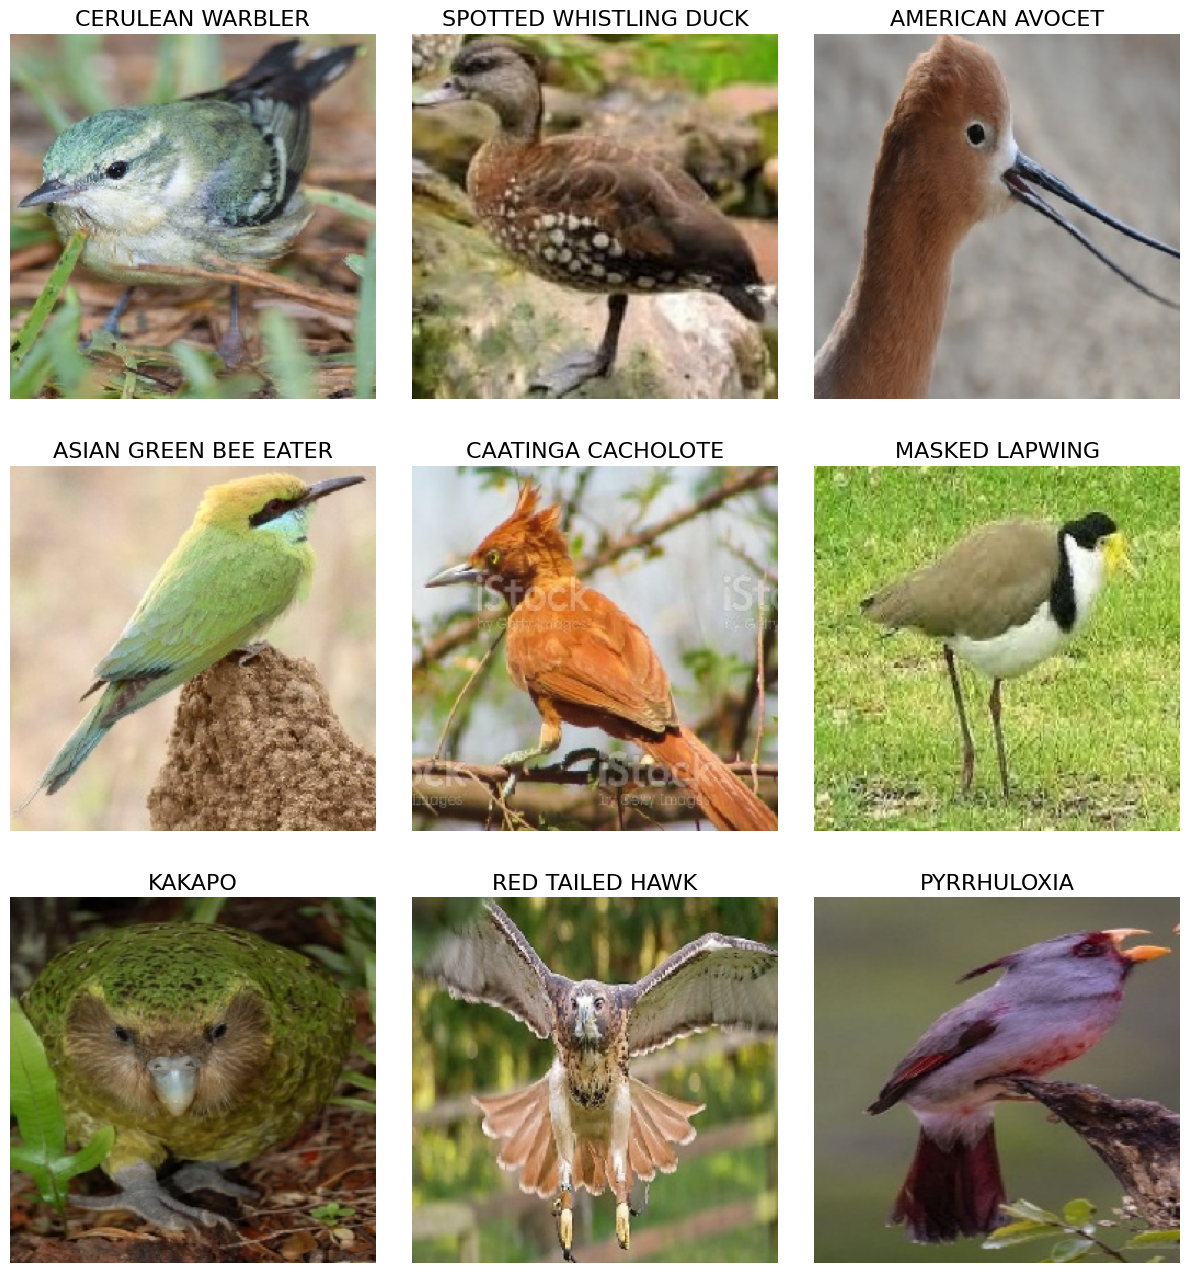

In [66]:
# displaying images from training data.
images, classes = next(training_data)
class_idxs = np.argmax(classes, axis=-1) # transform from one-hot array to class number
labels = [CLASSES[idx] for idx in class_idxs]
display_nine_birds(images, labels)

# Creating a model using Transfer Learning

In [67]:
from tensorflow.keras.applications import EfficientNetB3

#initialising the EfficientNetB3 model

base_model = EfficientNetB3(input_shape = training_data.image_shape,
                            include_top = False,
                            weights = 'imagenet',
                            pooling = 'max')



#freezing the layers of base model.

43941136/43941136 [==============================] - 0s 0us/step


In [68]:
# creating the model ont top of base model

with tf.device('/device:GPU:0'):
  def create_model():

    inputs = layers.Input(shape  = training_data.image_shape, name = 'input_layer')

    x = augmented_images(inputs)

    base_model_out = base_model(x, training = False)

    x = Dense(1050, activation = 'relu')(base_model_out)

    x = layers.BatchNormalization()(x)

    #x = Dense(180, activation  = 'relu')(x)

    x = Dropout(0.2)(x)

    #x = Dense(360, activation = 'relu')(x)

    #final layer
    outputs = Dense(525, activation = 'softmax', dtype = tf.float32, name = 'output_layer')(x)

    model = keras.models.Model(inputs = inputs, outputs = outputs)

    model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

  my_model = create_model()
  my_model.summary()


  epochs = 10


  callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                              patience = 3,
                                              restore_best_weights = True)
  history = my_model.fit(training_data,
                                          validation_data = validation_data,
                                          callbacks = [callback],
                                          verbose = 1,
                                          epochs = epochs)

  final_accuracy = history.history["val_accuracy"][-3:]
  print("FINAL ACCURACY (MEAN of last three val_accuracy): ", np.mean(final_accuracy))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 Augmenting_images (Sequent  (None, 256, 256, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense (Dense)               (None, 1050)              1613850   
                                                                 
 batch_normalization (Batch  (None, 1050)              4200      
 Normalization)                                                  
                                                             

In [69]:
#displaying the learning curves:

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

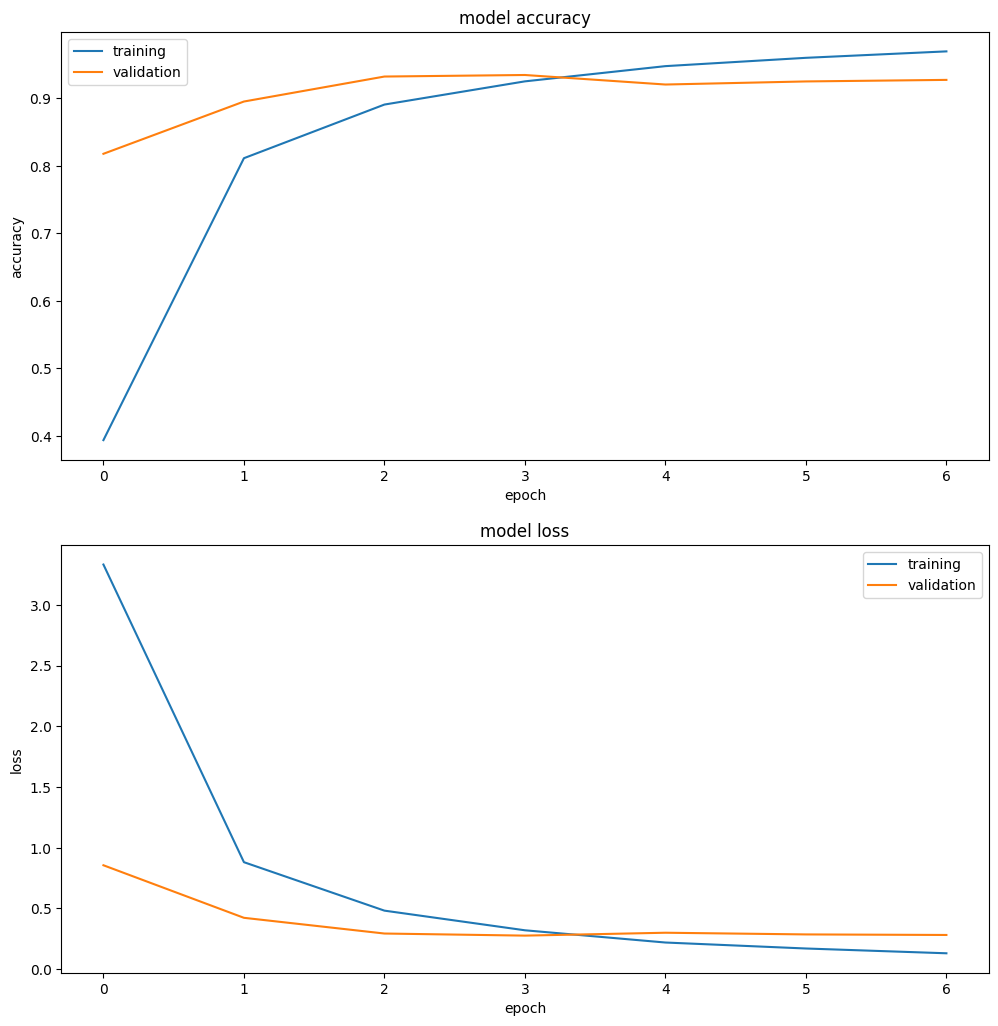

In [70]:
plt.subplots(figsize=(10,10))
plt.tight_layout()

display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)


In [71]:
#function for the evaluation of the model.
import seaborn as sns
def evaluate_and_plot_confusion_matrix(model, generator):
    # Generate predictions
    y_pred = model.predict(generator)

    # Convert predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Convert true labels to class labels
    y_true_classes = generator.classes

    # Get class labels
    class_labels = list(generator.class_indices.keys())

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 25))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Display classification report
    print('\nClassification Report:\n', classification_report(y_true_classes, y_pred_classes, target_names=class_labels))


175/175 [==============================] - 15s 72ms/step


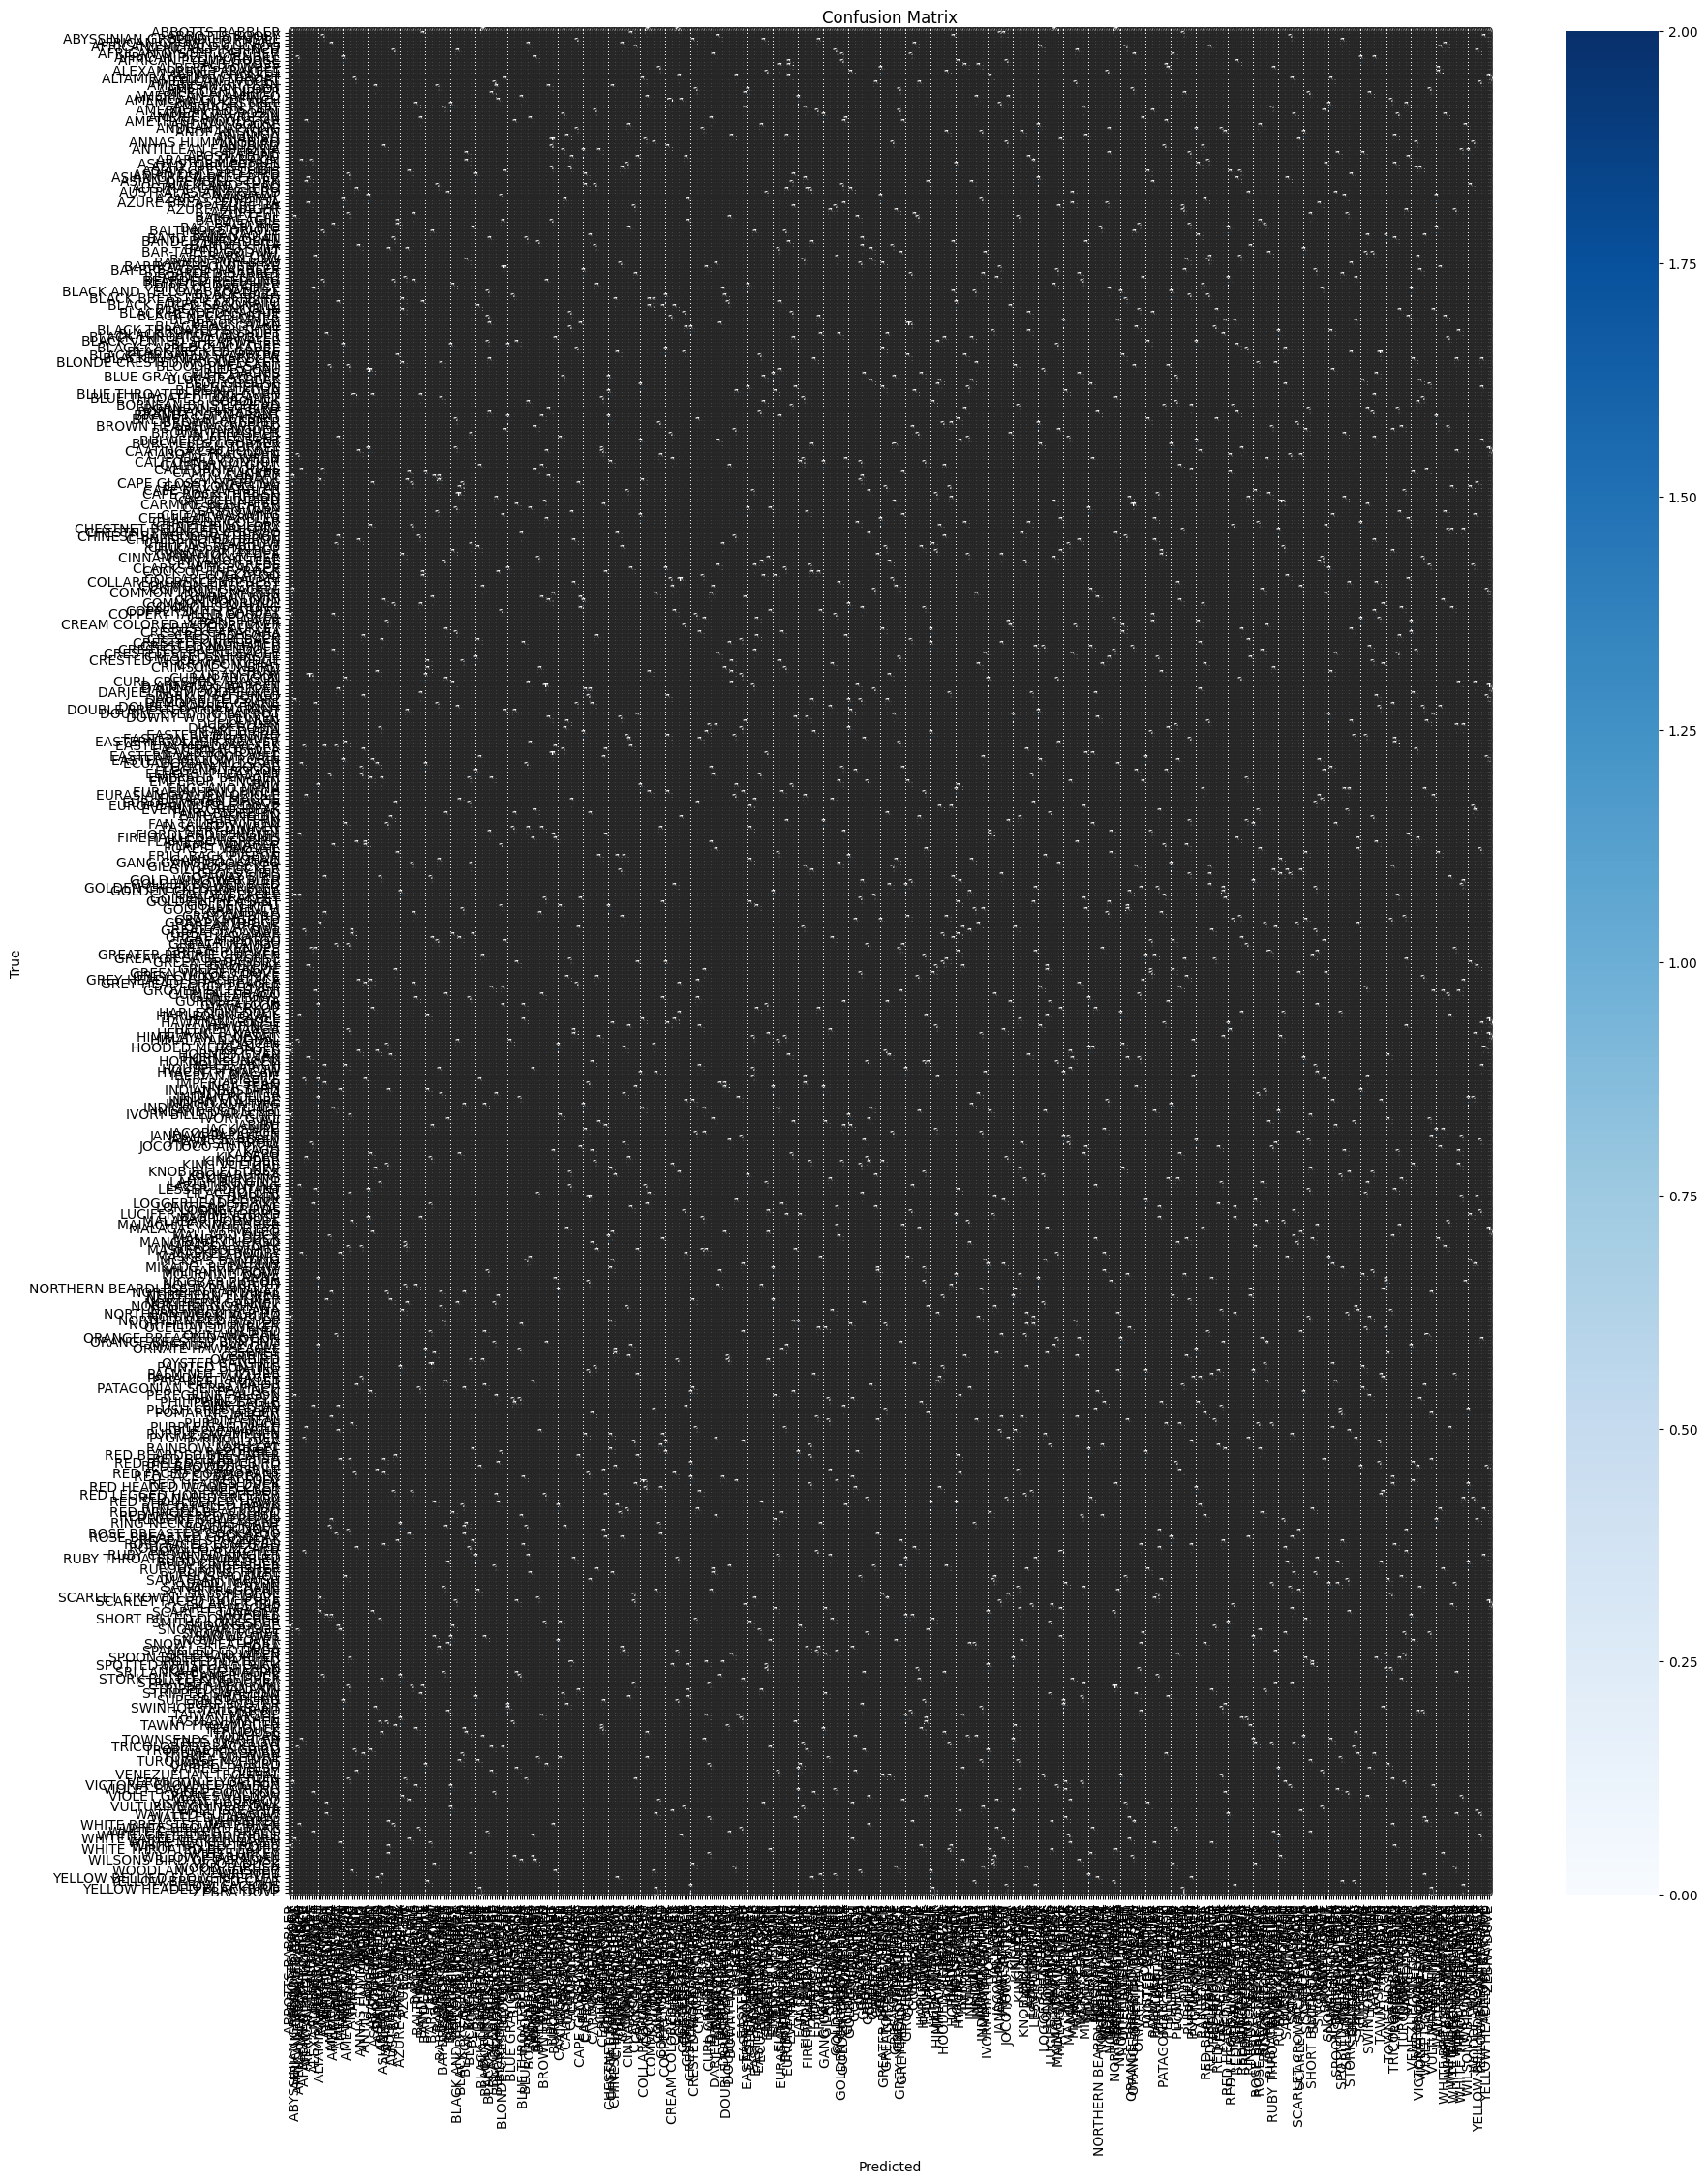


Classification Report:
                                precision    recall  f1-score   support

              ABBOTTS BABBLER       0.00      0.00      0.00         5
                ABBOTTS BOOBY       0.00      0.00      0.00         5
   ABYSSINIAN GROUND HORNBILL       0.00      0.00      0.00         5
        AFRICAN CROWNED CRANE       0.00      0.00      0.00         5
       AFRICAN EMERALD CUCKOO       0.00      0.00      0.00         5
            AFRICAN FIREFINCH       0.00      0.00      0.00         5
       AFRICAN OYSTER CATCHER       0.00      0.00      0.00         5
        AFRICAN PIED HORNBILL       0.00      0.00      0.00         5
          AFRICAN PYGMY GOOSE       0.00      0.00      0.00         5
                    ALBATROSS       0.00      0.00      0.00         5
               ALBERTS TOWHEE       0.00      0.00      0.00         5
         ALEXANDRINE PARAKEET       0.00      0.00      0.00         5
                ALPINE CHOUGH       0.00      0.00 

In [72]:
#plotting confusion matrix and calssifiaction report of  model(evaluating model)
evaluate_and_plot_confusion_matrix(my_model, test_data)

In [73]:
#defining the function to get the predicted label

def flower_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
  class_idx = np.argmax(label, axis=-1)
  prediction_idx = np.argmax(prediction, axis=-1)
  if class_idx == prediction_idx:
    return f'{CLASSES[prediction_idx]} [correct]', 'green'
  else:
    return f'{CLASSES[prediction_idx]} [incorrect, should be {CLASSES[class_idx]}]', 'red'

def get_titles(images, labels, model):
  predictions = model.predict(images)
  titles, colors = [], []
  for label, prediction in zip(classes, predictions):
    title, color = flower_title(label, prediction)
    titles.append(title)
    colors.append(color)
  return titles, colors

1/1 [==============================] - 0s 34ms/step


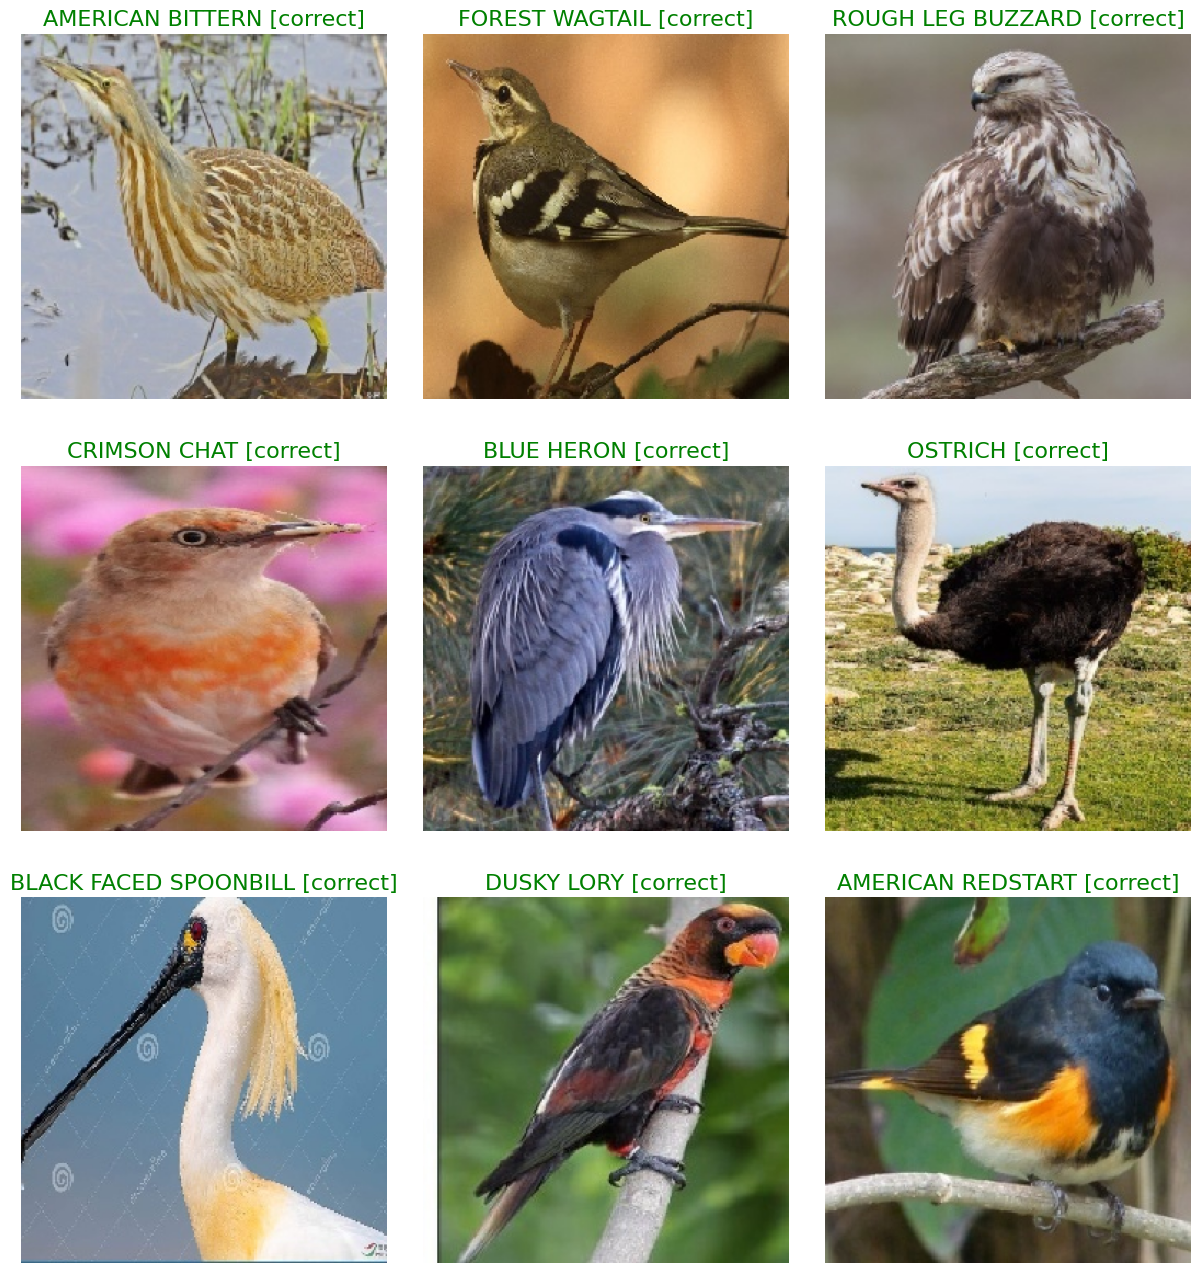

In [78]:
# displaying the predicted data of vgg19_model.
images, classes = next(test_data)
titles, colors = get_titles(images, classes, my_model)
display_nine_birds(images, titles, colors)

#Thank You